# Setup

In [1]:
import importlib
import os

import joblib
import pandas as pd

import tlp

url = 'http://konect.cc/files/download.tsv.epinions.tar.bz2'
dataset_id = '16'
adjusted_intervals = dict(t_split = pd.Timestamp('2001-01-10 00:00:00'))

# Download and extract data

In [2]:
filepath = f'{dataset_id}/edgelist.pkl'
if not os.path.isfile(filepath):
  edgelist = tlp.get_edgelist(url, dataset_id, verbose=True)
  joblib.dump(edgelist, filepath)

This is likely a signed network (weight equals -1). 
Only positive weights will be used.
          


# Splitting

In [3]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist), **adjusted_intervals)
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 43 ms, sys: 25.3 ms, total: 68.4 ms
Wall time: 122 ms


# Instances

In [4]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

CPU times: user 9min 4s, sys: 8.14 s, total: 9min 12s
Wall time: 9min 10s


# Targets

In [5]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

Determine targets:   0%|          | 0/33271662 [00:00<?, ?it/s]

CPU times: user 44.2 s, sys: 1.08 s, total: 45.3 s
Wall time: 45.1 s


# Sampling

In [6]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 677 ms, sys: 70.9 ms, total: 748 ms
Wall time: 774 ms


# Features

## AA (time agnostic)

In [7]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 4.92 s, sys: 62.9 ms, total: 4.99 s
Wall time: 4.99 s


## AA (time aware)

In [8]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

time strategies:   0%|          | 0/3 [00:00<?, ?it/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

CPU times: user 1min 56s, sys: 4.76 s, total: 2min 1s
Wall time: 1min 58s


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

In [9]:
joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'].sort_values().drop_duplicates()

1        2001-01-09 23:00:00
581863   2001-01-16 23:00:00
582139   2001-01-17 23:00:00
582468   2001-01-18 23:00:00
582715   2001-01-19 23:00:00
                 ...        
840329   2003-08-07 22:00:00
840489   2003-08-08 22:00:00
840791   2003-08-09 22:00:00
841139   2003-08-10 22:00:00
841335   2003-08-11 22:00:00
Name: datetime, Length: 939, dtype: datetime64[ns]

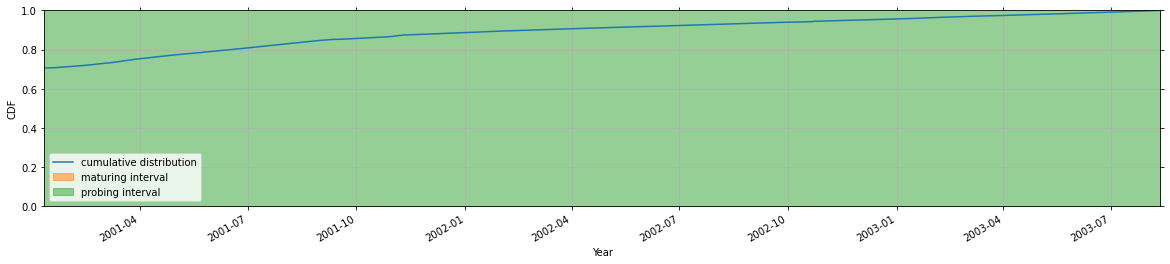

In [10]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'], **adjusted_intervals)

## Metric: Class imbalance

In [11]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,33254179,0.999475
True,17483,0.000525


## Figure: Datetime strategies

/scratch/bruingjde/miniconda3/envs/tlp/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:506: UserWarning: Attempting to set identical left == right == 11331.958333333334 results in singular transformations; automatically expanding.
  ax.set_xlim(self.xlim)


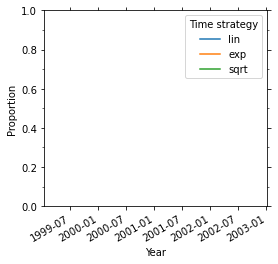

In [12]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

KeyError: 'pop from an empty set'

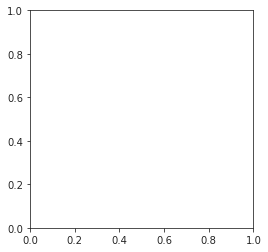

In [13]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

In [ ]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

In [ ]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [ ]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)